In [1]:
import pandas as pd

# Reload the dataset
data = pd.read_csv("clean.csv")

# Display basic statistical descriptions
data.describe()


,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,act,id
count,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06,1.412865e+06
mean,5.321167e-03,1.458119e-02,1.276031e-02,-3.910640e-03,4.424380e-02,3.927177e-02,2.950142e+00,1.147175e+01
std,1.292916e+00,1.226470e+00,8.080411e-01,3.282090e-01,5.275663e-01,3.762121e-01,1.643905e+00,6.924861e+00
min,-1.736579e+01,-1.841441e+01,-1.215124e+01,-6.369264e+00,-5.673592e+00,-7.743481e+00,0.000000e+00,0.000000e+00
25%,-2.860300e-01,-1.669860e-01,-9.733300e-02,-4.751300e-02,-6.213600e-02,-2.361300e-02,2.000000e+00,6.000000e+00
50%,-3.940000e-04,3.250000e-04,1.770000e-04,8.910000e-04,4.336000e-03,3.433000e-03,3.000000e+00,1.200000e+01
75%,1.163210e-01,2.312710e-01,1.133280e-01,4.428400e-02,5.176600e-02,1.047770e-01,4.000000e+00,1.800000e+01
max,1.046806e+01,1.754312e+01,1.143624e+01,7.120793e+00,7.322722e+00,8.125357e+00,5.000000e+00,2.300000e+01


Oversampling to balance the classes

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv("clean.csv")

# Split the unique ids into train and test sets
train_ids, test_ids = train_test_split(data['id'].unique(), test_size=0.2, random_state=42)

# Create train and test datasets based on the split ids
train_data = data[data['id'].isin(train_ids)]
test_data = data[data['id'].isin(test_ids)]

# Check the distribution of the target label 'act' in the train dataset
class_distribution = train_data['act'].value_counts()

# Find the maximum count among all classes
max_count = class_distribution.max()

# Oversample the minority classes
oversampled_data = []
for label, count in class_distribution.items():
    # If this class is a minority class, oversample it
    if count < max_count:
        samples_to_add = max_count - count
        samples_from_class = train_data[train_data['act'] == label]
        
        # Oversample by randomly sampling with replacement
        oversampled_samples = samples_from_class.sample(samples_to_add, replace=True)
        oversampled_data.append(oversampled_samples)

oversampled_data = pd.concat(oversampled_data, axis=0)
train_data_oversampled = pd.concat([train_data, oversampled_data], axis=0)

# Save the oversampled train data and test data to CSV files
train_data_oversampled.to_csv("train_data_oversampled.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

# Print the lengths of train_data_oversampled and test_data
print(len(train_data_oversampled), len(test_data))

1654146 300229


train_data_oversampled.csv 1D CNN model code. It will train the model and then test it using test_data.csv and output the accuracy, ROC-AUC, and F1 score

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import LabelBinarizer

# Load the datasets
train_data = pd.read_csv("train_data_oversampled.csv")
test_data = pd.read_csv("test_data.csv")

# Define a function to prepare data based on fixed length
sequence_length = 128
def prepare_data_fixed_length(data):
    X = data.drop(columns=['act', 'id']).values
    y = data['act'].values
    
    X_sequences = []
    y_sequences = []
    
    for i in range(0, len(X) - sequence_length + 1, sequence_length):
        X_sequences.append(X[i:i+sequence_length])
        y_sequences.append(y[i])
        
    return np.array(X_sequences), np.array(y_sequences)

X_train, y_train = prepare_data_fixed_length(train_data)
X_test, y_test = prepare_data_fixed_length(test_data)

# Convert labels to one-hot encoded format
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Define the 1D CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(128, 6)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"ROC-AUC: {roc_auc}")
print(f"F1 Score: {f1}")


Epoch 1/10
  1/404 [..............................] - ETA: 1:04 - loss: 1.9388 - accuracy: 0.1562

2023-10-01 20:29:13.839838: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


404/404 [==============================] - 1s 3ms/step - loss: 0.5825 - accuracy: 0.7966
Epoch 2/10
404/404 [==============================] - 1s 3ms/step - loss: 0.2260 - accuracy: 0.9232
Epoch 3/10
404/404 [==============================] - 1s 2ms/step - loss: 0.1650 - accuracy: 0.9399
Epoch 4/10
404/404 [==============================] - 1s 2ms/step - loss: 0.1275 - accuracy: 0.9530
Epoch 5/10
404/404 [==============================] - 1s 2ms/step - loss: 0.1019 - accuracy: 0.9629
Epoch 6/10
404/404 [==============================] - 1s 2ms/step - loss: 0.0805 - accuracy: 0.9711
Epoch 7/10
404/404 [==============================] - 1s 2ms/step - loss: 0.0783 - accuracy: 0.9695
Epoch 8/10
404/404 [==============================] - 1s 2ms/step - loss: 0.0663 - accuracy: 0.9750
Epoch 9/10
404/404 [==============================] - 1s 2ms/step - loss: 0.0477 - accuracy: 0.9812
Epoch 10/10
74/74 [==============================] - 0s 753us/step
Accuracy: 0.8690831556503198
ROC-AUC: 0.9660

For comparison, you need to take the original unoversampled training data and feed it into the same CNN model for training. Then, the same test_data.csv is used for testing and the performance metrics are calculated

In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import LabelBinarizer

# Load the datasets
train_data = pd.read_csv("clean.csv")
test_data = pd.read_csv("test_data.csv")  # Assuming you have saved this from the previous steps

# Define a function to prepare data based on fixed length
sequence_length = 128
def prepare_data_fixed_length(data):
    X = data.drop(columns=['act', 'id']).values
    y = data['act'].values
    
    X_sequences = []
    y_sequences = []
    
    for i in range(0, len(X) - sequence_length + 1, sequence_length):
        X_sequences.append(X[i:i+sequence_length])
        y_sequences.append(y[i])
        
    return np.array(X_sequences), np.array(y_sequences)

X_train, y_train = prepare_data_fixed_length(train_data)
X_test, y_test = prepare_data_fixed_length(test_data)

# Convert labels to one-hot encoded format
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Define the 1D CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(128, 6)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(6, activation='softmax'))

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"ROC-AUC: {roc_auc}")
print(f"F1 Score: {f1}")


Epoch 1/10
345/345 [==============================] - 1s 2ms/step - loss: 0.7248 - accuracy: 0.7496
Epoch 2/10
345/345 [==============================] - 1s 2ms/step - loss: 0.2966 - accuracy: 0.8932
Epoch 3/10
345/345 [==============================] - 1s 2ms/step - loss: 0.2010 - accuracy: 0.9282
Epoch 4/10
345/345 [==============================] - 1s 2ms/step - loss: 0.1397 - accuracy: 0.9499
Epoch 5/10
345/345 [==============================] - 1s 2ms/step - loss: 0.1114 - accuracy: 0.9598
Epoch 6/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0908 - accuracy: 0.9671
Epoch 7/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0700 - accuracy: 0.9763
Epoch 8/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0703 - accuracy: 0.9733
Epoch 9/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0627 - accuracy: 0.9777
Epoch 10/10
74/74 [==============================] - 0s 633us/step
Accuracy: 0.9530916844349681
ROC-

The performance of the model trained with the original data is better compared to the results previously obtained using oversampled data. This may be because oversampling may lead to overfitting of some classes.

Segmentation

In [11]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import LabelBinarizer

# Load the datasets
train_data = pd.read_csv("clean.csv")
test_data = pd.read_csv("test_data.csv")

# Define a function to prepare data based on fixed length for segmentation
sequence_length = 128
def prepare_data_fixed_length(data):
    X = data.drop(columns=['act', 'id']).values
    y = data['act'].values
    
    X_sequences = []
    y_sequences = []
    
    for i in range(0, len(X) - sequence_length + 1, sequence_length):
        X_sequences.append(X[i:i+sequence_length])
        y_sequences.append(y[i])
        
    return np.array(X_sequences), np.array(y_sequences)

X_train, y_train = prepare_data_fixed_length(train_data)
X_test, y_test = prepare_data_fixed_length(test_data)

# Convert labels to one-hot encoded format
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Define the 1D CNN model for Segmentation
model_segmentation = Sequential()
model_segmentation.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(128, 6)))
model_segmentation.add(MaxPooling1D(pool_size=2))
model_segmentation.add(Flatten())
model_segmentation.add(Dense(100, activation='relu'))
model_segmentation.add(Dense(6, activation='softmax'))

# Compile and train the model
model_segmentation.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_segmentation.fit(X_train, y_train, epochs=10, batch_size=32)

# Predictions for Segmentation
y_pred_probs_segmentation = model_segmentation.predict(X_test)
y_pred_segmentation = np.argmax(y_pred_probs_segmentation, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics for Segmentation
accuracy_segmentation = accuracy_score(y_true, y_pred_segmentation)
roc_auc_segmentation = roc_auc_score(y_test, y_pred_probs_segmentation, multi_class='ovr')
f1_segmentation = f1_score(y_true, y_pred_segmentation, average='weighted')

print(f"Segmentation - Accuracy: {accuracy_segmentation}")
print(f"Segmentation - ROC-AUC: {roc_auc_segmentation}")
print(f"Segmentation - F1 Score: {f1_segmentation}")

Epoch 1/10
345/345 [==============================] - 1s 2ms/step - loss: 0.6741 - accuracy: 0.7742
Epoch 2/10
345/345 [==============================] - 1s 3ms/step - loss: 0.2899 - accuracy: 0.8952
Epoch 3/10
345/345 [==============================] - 1s 2ms/step - loss: 0.2046 - accuracy: 0.9244
Epoch 4/10
345/345 [==============================] - 1s 2ms/step - loss: 0.1465 - accuracy: 0.9473
Epoch 5/10
345/345 [==============================] - 1s 2ms/step - loss: 0.1128 - accuracy: 0.9584
Epoch 6/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0893 - accuracy: 0.9681
Epoch 7/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0800 - accuracy: 0.9712
Epoch 8/10
345/345 [==============================] - 1s 3ms/step - loss: 0.0623 - accuracy: 0.9761
Epoch 9/10
345/345 [==============================] - 1s 3ms/step - loss: 0.0763 - accuracy: 0.9725
Epoch 10/10
74/74 [==============================] - 0s 621us/step
Segmentation - Accuracy: 0.935607

Weighted Loss

In [12]:
# Calculate class weights for weighted loss
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define the 1D CNN model for Weighted Loss
model_weighted_loss = Sequential()
model_weighted_loss.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(128, 6)))
model_weighted_loss.add(MaxPooling1D(pool_size=2))
model_weighted_loss.add(Flatten())
model_weighted_loss.add(Dense(100, activation='relu'))
model_weighted_loss.add(Dense(6, activation='softmax'))

# Compile and train the model using weighted loss
model_weighted_loss.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_weighted_loss.fit(X_train, y_train, epochs=10, batch_size=32, class_weight=class_weights_dict)

# Predictions for Weighted Loss
y_pred_probs_weighted = model_weighted_loss.predict(X_test)
y_pred_weighted = np.argmax(y_pred_probs_weighted, axis=1)

# Calculate metrics for Weighted Loss
accuracy_weighted = accuracy_score(y_true, y_pred_weighted)
roc_auc_weighted = roc_auc_score(y_test, y_pred_probs_weighted, multi_class='ovr')
f1_weighted = f1_score(y_true, y_pred_weighted, average='weighted')

print(f"Weighted Loss - Accuracy: {accuracy_weighted}")
print(f"Weighted Loss - ROC-AUC: {roc_auc_weighted}")
print(f"Weighted Loss - F1 Score: {f1_weighted}")


Epoch 1/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0061 - accuracy: 0.6841
Epoch 2/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0026 - accuracy: 0.8714
Epoch 3/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0019 - accuracy: 0.9059
Epoch 4/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0014 - accuracy: 0.9273
Epoch 5/10
345/345 [==============================] - 1s 2ms/step - loss: 0.0011 - accuracy: 0.9420
Epoch 6/10
345/345 [==============================] - 1s 2ms/step - loss: 9.2189e-04 - accuracy: 0.9512
Epoch 7/10
345/345 [==============================] - 1s 2ms/step - loss: 8.3268e-04 - accuracy: 0.9560
Epoch 8/10
345/345 [==============================] - 1s 2ms/step - loss: 6.7963e-04 - accuracy: 0.9626
Epoch 9/10
345/345 [==============================] - 1s 2ms/step - loss: 4.8234e-04 - accuracy: 0.9735
Epoch 10/10
74/74 [==============================] - 0s 654us/step
Weighted Loss - A

Original model:
Accuracy:
0.9514
ROC-AUC:
0.9900
F1 score:
0.9507

Time window Segmentation:
Accuracy:
0.9356
ROC-AUC:
0.9873
F1 score:
0.9317

Weighted Loss:
Accuracy:
0.9424
ROC-AUC:
0.9879
F1 score:
0.9408
In summary, the original model performs the best among all three methods, especially in terms of accuracy and F1 score. The time window partition and weighted loss methods perform similarly, but slightly worse than the original model.

These results suggest that for your specific dataset and problem, the raw data (without oversampling or other processing) may provide the best performance on the CNN model. This also highlights the importance of first evaluating the performance of the raw data before applying any processing or sampling technique.

In [ ]:
outlier visualization

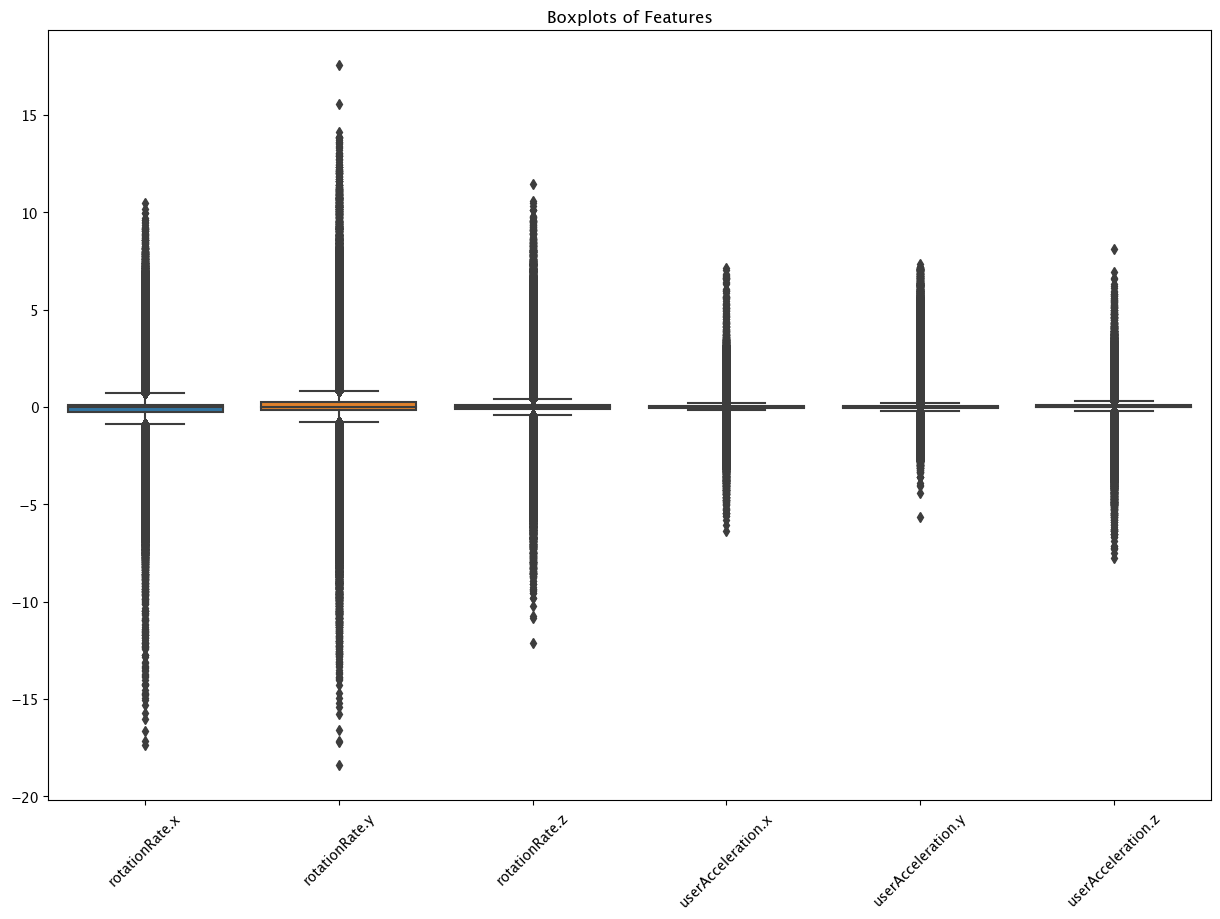

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("clean.csv")

# Drop non-numeric columns
numeric_data = data.drop(columns=['act', 'id'])

# Plot boxplots for each feature
plt.figure(figsize=(15, 10))
sns.boxplot(data=numeric_data)
plt.title('Boxplots of Features')
plt.xticks(rotation=45)
plt.show()


In [14]:
import pandas as pd

# Load the dataset
data = pd.read_csv("clean.csv")

# Drop non-numeric columns for outlier detection
numeric_data = data.drop(columns=['act', 'id'])

# Function to detect outliers using IQR method
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers

# Detect and store outliers for each feature
outliers_data = {}
for feature in numeric_data.columns:
    outliers = detect_outliers(data, feature)
    outliers_data[feature] = outliers

# Return the number of outliers detected for each feature
outliers_counts = {feature: len(outliers) for feature, outliers in outliers_data.items()}
print(outliers_counts)


{'rotationRate.x': 468990, 'rotationRate.y': 415166, 'rotationRate.z': 456628, 'userAcceleration.x': 409147, 'userAcceleration.y': 469983, 'userAcceleration.z': 361232}
